# <span style="color:#F72585">Predicción de secuencia de valores futuros de una acción. Apple (LSTM)</span>

## <span style="color:#4361EE">Importar las librería requeridas</span>

In [1]:
#
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

Versión de Tensorflow:  2.9.1


## <span style="color:#4361EE">Lectura de  los datos</span>

Estos datos corresponden a la empresa *Apple*. Son  3019 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 3 de enero de 2006 hasta el 1 de enero de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre,  *Volume* es el volúmenes de acciones transadas en el día  y *Name* es el código de identificación de la empresa, Apple en este caso.


Los datos puede ser bajados directamente de [Kaggle](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [2]:
#reading from a local file

df = pd.read_csv('https://raw.githubusercontent.com/AprendizajeProfundo/Libro-Fundamentos/main/Redes_Recurrentes/Datos/AAPL_2006-01-01_to_2018-01-01.csv')


In [3]:
# looking at the first five rows of the data
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para invertir la tabla, debido a que los datos contienen las observaciones más recientes en la parte superior de la tabla.

## <span style="color:#4361EE">Extrae datos para la serie que se desea predecir-close</span>

In [4]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


## <span style="color:#4361EE">Visualización de la serie precio al cierre</span>


In [5]:
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 3019
len_test = len_data- len_train # 20% = 2415
print (len_data, '=', len_train, '+',len_test)

3019 = 2415 + 604


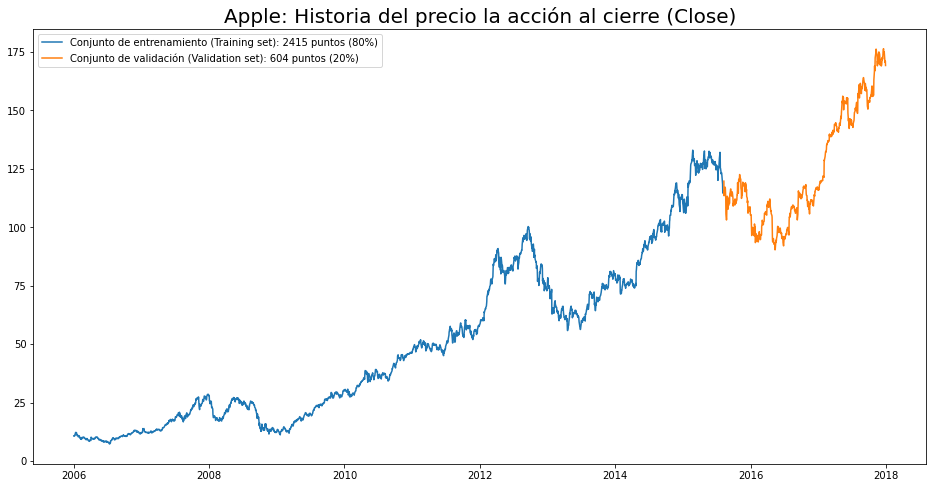

In [6]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## <span style="color:#4361EE">Preparación de los datos para el entrenamiento de la red LSTM</span>

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.

### <span style="color:#4CC9F0">Primero extrae los valores y se crea el  objeto MinMaxScaler</span>

In [7]:
#creating train and test sets
dataset = data.values


# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

In [8]:
dataset.shape

(3019,)

### <span style="color:#4CC9F0">Crea datos de entrenamiento</span>

 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 5 datos (la predicción a
 partir de esos "time_step" datos se hace para los siguentes 5 días). Se conformará de esta forma el set de entrenamiento

1. Número de datos consecutivos para entrenamiento: time_step = 60. 
2. Días a predecir: days = 1

### <span style="color:#4CC9F0">Función para crear los datos de entrenamiento</span>

In [9]:
def multipaso_data(dataset, target, start_index, end_index, history_size,
                      target_size,  single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Se coloca una semilla para gerantizar reproductibidad

In [10]:
tf.random.set_seed(100)

In [11]:
#
# hiperparámetros para crear las secuencias
#
# tamaño de pasos a futuro
future_target = 10

# tamaño secuencias de entrada
past_history = 60 

TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿer0 de datos entreno

# Crea los datos
X_train, y_train = multipaso_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
X_test, y_test = multipaso_data(dataset, dataset, TRAIN_SPLIT,
                                                 None, past_history,
                                                 future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2415
(2355, 60)
(2355, 10)
(534, 60)
(534, 10)


## <span style="color:#4361EE">Crea el modelo LSTM</span>

Omitimos esta sección. Usaremso el modelo entrenado a un día

In [12]:
# shapes
input_shape = (X_train.shape[1], 1)
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.0, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.0, name= 'Dropout_02')(x)
outputs = Dense(future_target)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()


Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 60, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


## <span style="color:#4361EE">Compila</span>


Se usará el optimizador Adam y la función de pérdida MSE

In [13]:
model_01.compile(loss='mean_squared_error',
  optimizer=Adam(0.001))


## <span style="color:#4361EE">Lee modelo preentrenado a un día</span>

### <span style="color:#4CC9F0">Entrena el modelo</span>


In [14]:
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
history = model_01.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/40
67/67 [==============================] - 9s 60ms/step - loss: 0.0044 - val_loss: 0.0273
Epoch 2/40
67/67 [==============================] - 3s 40ms/step - loss: 0.0079 - val_loss: 0.0122
Epoch 3/40
67/67 [==============================] - 3s 41ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/40
67/67 [==============================] - 3s 39ms/step - loss: 0.0014 - val_loss: 9.5578e-04
Epoch 5/40
67/67 [==============================] - 3s 41ms/step - loss: 4.3329e-04 - val_loss: 9.3428e-04
Epoch 6/40
67/67 [==============================] - 3s 39ms/step - loss: 2.9866e-04 - val_loss: 8.7440e-04
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 3.3066e-04 - val_loss: 8.5611e-04
Epoch 8/40
67/67 [==============================] - 3s 39ms/step - loss: 2.9848e-04 - val_loss: 8.2353e-04
Epoch 9/40
67/67 [==============================] - 3s 43ms/step - loss: 3.2923e-04 - val_loss: 8.0485e-04
Epoch 10/40
67/67 [==============================] - 3s 39ms/step

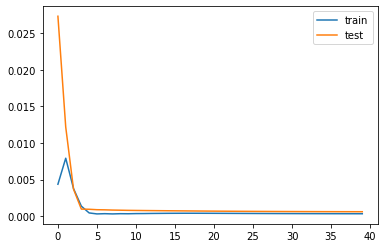

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## <span style="color:#4361EE">Predicciones</span>

### <span style="color:#4CC9F0">Prepara los datos de validación</span>

In [16]:
X_test.shape

(534, 60)

### <span style="color:#4CC9F0">Calcula predicciones</span>


In [17]:
# predictions
prediction = model_01.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

17/17 [==============================] - 1s 15ms/step


In [18]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)


(534, 60)
(534, 10)
(534, 10)


### <span style="color:#4CC9F0">Prepara datos para mostrar predicciones</span>


In [19]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

#print(y_train_p.shape)
#print(y_test_p.shape)
#print(y_pred_p.shape)

### <span style="color:#4CC9F0">Gráfica de las predicciones</span>


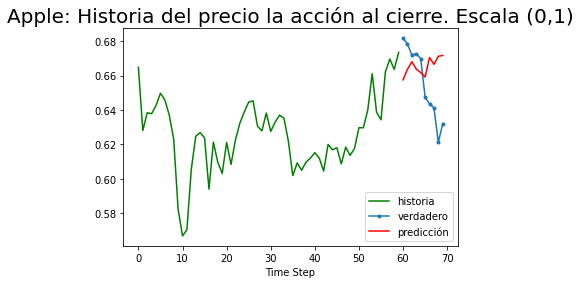

In [20]:
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', label="historia")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

## <span style="color:#4361EE">Guarda el modelo entrenado</span>

In [21]:
model_01.save('../Datos/modelo_Apple_3_dia_multipl3.h5')

## <span style="color:#4361EE">Intervalos de confianza. TO DO</span>

In [22]:
model_01.get_config()

{'name': 'series_LSTM_model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 60, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Dropout',
   'config': {'name': 'Dropout_01',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.0,
    'noise_shape': None,
    'seed': None},
   'name': 'Dropout_01',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'LSTM',
   'config': {'name': 'LSTM_layer',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'shared_object_id': 2},
    'recurren

## <span style="color:#4361EE">Referencias</span>

1. [Introducción a Redes LSTM](Intro_LSTM.ipynb)
1. [Time Series Forecasting with LSTMs using TensorFlow 2 and Keras in Python](https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651/)
1. [Dive into Deep Learnig](https://d2l.ai/)
1. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
1. Ralf C. Staudemeyer and Eric Rothstein Morris,[*Understanding LSTM a tutorial into Long Short-Term Memory Recurrent Neural Networks*](https://arxiv.org/pdf/1909.09586.pdf), arxiv, September 2019
1. Karpathy, [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
1. Anton Lucanus, [Making Automation More Efficient by Learning from Historical Trade Data](https://datafloq.com/read/making-automation-more-efficient-by-learning-from-/7444), 8:43 AM, January 7, 2020
1. https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
1. https://www.youtube.com/watch?v=2BrpKpWwT2A&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ&index=1
1. https://towardsdatascience.com/using-lstms-for-stock-market-predictions-tensorflow-9e83999d4653
1. https://github.com/llSourcell/Reinforcement_Learning_for_Stock_Prediction/blob/master/README.md